In [1]:
import numpy as np
from numba import njit, prange
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class ESN():
    
    def __init__(self, N, inputs, dt, beta, initTraining, sigma, mu, seed = 42):
        """
        ----------
        Initialize the network.
        The target is set to the inputs at the next timestep, so that the
        network learns to generate the timeseries of the inputs.
        ----------
                      N : number of neurons in the reservoir
                 inputs : inputs to the network, shape inputs_dim x T
                     dt : integration step
                   beta : regularization parameter
            initTrainig : step at which the training start, to avoid the
                          initial transient
                   seed : seed for the random number generator
                  sigma : variance of the Gaussian weights of the recurrent
                          network
                     mu : mean of the Gaussian weights of the recurrent
                          network
        """
        np.random.seed(seed)
        
        self.N = N
        self.inputs = inputs
        self.initTraining = initTraining
        self.dt = dt
        self.beta = beta

        self.T, self.inputs_dim = inputs.shape
        
        self.target = self.inputs[self.initTraining + 1:].T
        
        #############################
        # Initialize the matrix of the network that are not going to
        # be trained. Make sure that the spectral radius of the recurrent
        # matrix is not too large.
        #############################
        
        self.Wrec = np.random.randn(self.N, self.N)*sigma + mu #np.random.rand(self.N, self.N) - 0.5
        self.Wrec *= 1.25 / np.max(abs(np.linalg.eigvals(self.Wrec)))
    
        self.bias = np.random.randn(self.N)
        self.Win = np.random.randn(self.N, self.inputs_dim)
    
    def dynamical_step(self, xt, u):
        """
        ----------
        Step of the recurrent dynamics.
        ----------
            xt : state of the recurrent network at time t
            u : inputs to the recurrent network at time t
        """
        return xt + self.dt*(-xt + np.tanh(self.bias + np.dot(self.Win, u) + np.dot(self.Wrec, xt)))
    
    def burnout(self):
        """
        ----------
        Burnout period to avoid unwanted dependencies on the initial
        conditions of the recurrent network.
        ----------
        """
        xt = np.random.randn(self.N)*0.5
        
        for t in range(self.initTraining):
            xt = self.dynamical_step(xt, self.inputs[t])
        
        return xt
        
    def train(self):
        """
        ----------
        Train the network via Ridge regression.
        First compute the states of the recurrent network at all times, then use
        them to infer the readout matrix Wout.
        ----------
        """
        u = self.inputs[self.initTraining:-1]
        
        x = np.zeros((self.N, self.T - self.initTraining))
        x[:, 0] = self.burnout()
        
        for t in range(self.T - self.initTraining - 1):
            x[:,t+1] = self.dynamical_step(x[:,t], u[t])
        
        X = np.concatenate([np.ones(self.T - self.initTraining - 1)[None, ...], u.T, x[:,1:]])
        self.Wout = np.dot(np.dot(self.target, X.T), np.linalg.inv(np.dot(X, X.T) + beta*np.eye(1 + self.inputs_dim + self.N)))
        self.X = X
        
        trained_output = np.dot(self.Wout, X)
        MSE = np.sum(np.sqrt((((trained_output - self.target)**2).sum(axis = 1)/self.T))/self.inputs_dim)        
        
        return trained_output, MSE
    
    def echo_state(self, start_echo_state, duration = None):
        """
        ----------
        Perform an echo state loop. After a given time, the network is not
        not feeded the inputs, but its own outputs at the previous timestep.
        Note that we trained the network so that, for a given input, its
        output target is exactly the input at the next timestep.
        ----------
            start_echo_state : timestep at which the echo state loop
                               starts
        """
        if duration is None:
            duration = self.X.shape[-1]
            
        xt = self.X[1 + self.inputs_dim:, 0]
        u = self.X[1:self.inputs_dim + 1, 1:].T
        
        echo_output = np.zeros((self.inputs_dim, duration))
        for t in range(duration):
            if t <= start_echo_state:
                inputs = u[t]
            else:
                inputs = echo_output[:, t-1]
            xt = self.dynamical_step(xt, inputs)
            echo_output[:, t] = self.Wout[:,0] + np.dot(self.Wout[:, 1:self.inputs_dim+1], inputs) + np.dot(self.Wout[:,self.inputs_dim+1:], xt)
        
        return echo_output

# Chaotic 1D signal

In [4]:
def generate_nonlinear_data(T, dim = 1):
    b   = 0.1
    c   = 0.2
    tau = 17

    data = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
            1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]
    for n in range(17, 2*T + 99):
        data.append(data[n] - b*data[n] + c*data[n-tau]/(1 + data[n-tau]**10))
        
    if dim == 1:
        return np.array(data[100:T + 100])[..., None]
    else:
        return np.vstack([data[100:T + 100], data[T + 100:]]).T

In [5]:
N = 100
T = 2000
inputs = generate_nonlinear_data(T)

dt = 0.3
beta = 1e-4
initTraining = 100

sigma = 0.5
mu = 0

0.0017794099962263436


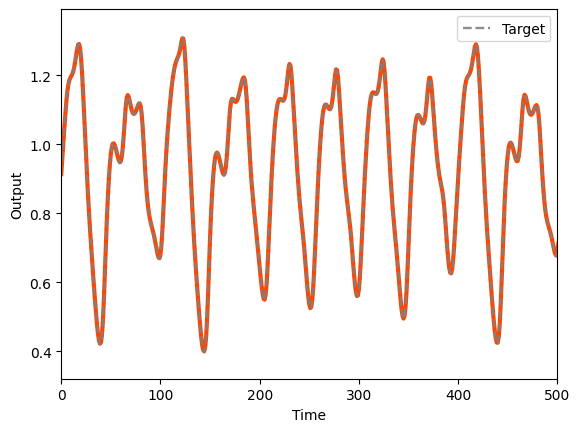

In [6]:
ESNet = ESN(N, inputs, dt, beta, initTraining, sigma, mu)
trained_output, MSE = ESNet.train()
print(MSE)

plt.plot(trained_output.T, lw = 3, color = "orangered")
plt.plot(ESNet.target.T, ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(0,500)
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()


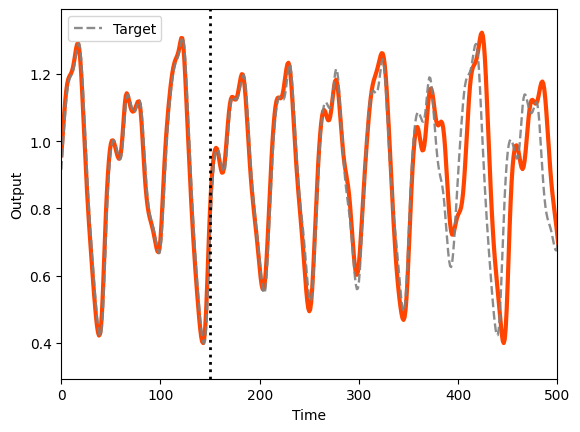

In [7]:
start_echo_state = 150
echo_output = ESNet.echo_state(start_echo_state)

plt.plot(echo_output.T, lw = 3, color = "orangered")
plt.plot(ESNet.target.T, ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(0,500)
plt.xlabel("Time")
plt.ylabel("Output")
plt.axvline(start_echo_state, ls = "dotted", c = 'k', lw = 2)
plt.legend()
plt.show()

# Periodic 1D signal

In [8]:
Time = np.linspace(0,20,1000)
signal = np.sin(5*np.pi*Time) + np.sin(2*np.pi*Time)

In [9]:
N = 1000

dt = 0.2
beta = 1e-4
initTraining = 200

sigma = 1
mu = 0.

3.887599964614489e-05


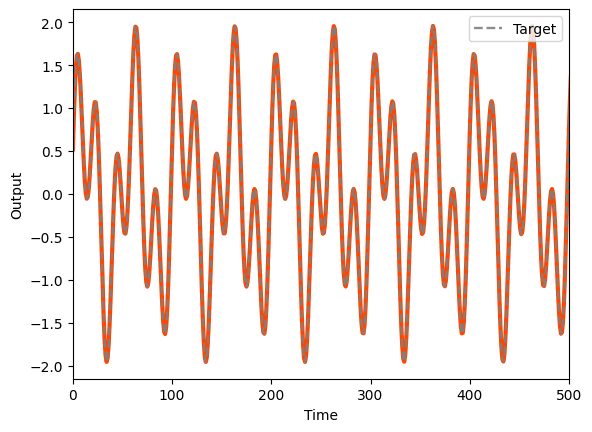

In [10]:
ESNet = ESN(N, signal[..., None], dt, beta, initTraining, sigma, mu)
trained_output, MSE = ESNet.train()
print(MSE)

plt.plot(trained_output.T, lw = 3, color = "orangered")
plt.plot(ESNet.target.T, ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(0,500)
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.show()

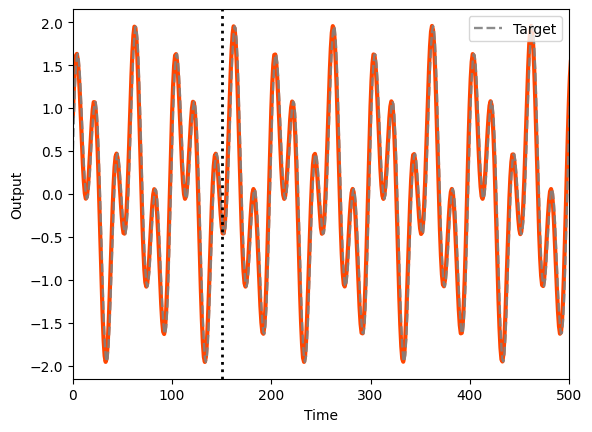

In [11]:
start_echo_state = 150
echo_output = ESNet.echo_state(start_echo_state)

plt.plot(echo_output.T, lw = 3, color = "orangered")
plt.plot(ESNet.target.T, ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(0,500)
plt.xlabel("Time")
plt.ylabel("Output")
plt.axvline(start_echo_state, ls = "dotted", c = 'k', lw = 2)
plt.legend()
plt.show()

# Periodic 2D signal

## Simpler signal

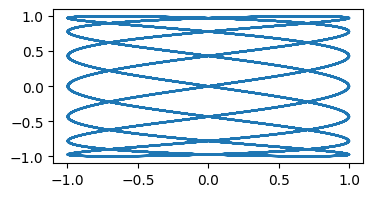

In [19]:
Time = np.linspace(0,40,2000)
signal_2D = np.array([np.sin(3.5*np.pi*Time), np.sin(1*np.pi*Time)])
plt.figure(figsize = (4,2))
plt.plot(signal_2D[0], signal_2D[1])
plt.show()

In [20]:
N = 1000

dt = 0.2
beta = 1e-4
initTraining = 200

sigma = 1
mu = 0.

In [21]:
ESNet = ESN(N, signal_2D.T, dt, beta, initTraining, sigma, mu)
trained_output, MSE = ESNet.train()
print(MSE)

7.121217170148633e-06


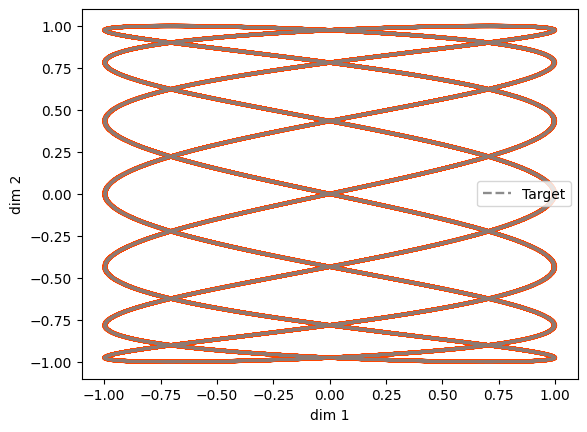

In [22]:
plt.plot(trained_output[0], trained_output[1], lw = 3, color = "orangered")
plt.plot(ESNet.target[0], ESNet.target[1], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.legend()
plt.show()

In [26]:
start_echo_state = 150
duration = 10000
echo_output = ESNet.echo_state(start_echo_state, duration = duration)

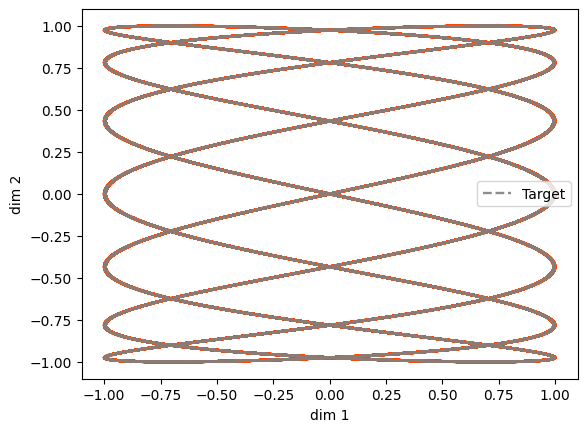

In [27]:
plt.plot(echo_output[0], echo_output[1], lw = 2, color = "orangered")
plt.plot(ESNet.target[0], ESNet.target[1], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.legend()
plt.show()

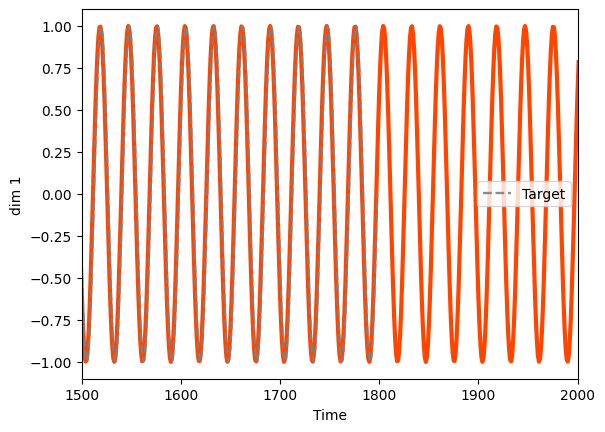

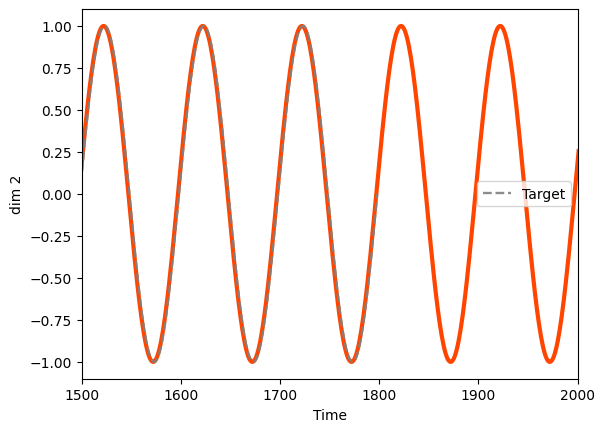

In [30]:
plt.plot(echo_output[0], lw = 3, color = "orangered")
plt.plot(ESNet.target[0], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(1500,2000)
plt.xlabel("Time")
plt.ylabel("dim 1")
plt.axvline(start_echo_state, ls = "dotted", c = 'k', lw = 2)
plt.legend()
plt.show()

plt.plot(echo_output[1], lw = 3, color = "orangered")
plt.plot(ESNet.target[1], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(1500,2000)
plt.xlabel("Time")
plt.ylabel("dim 2")
plt.axvline(start_echo_state, ls = "dotted", c = 'k', lw = 2)
plt.legend()
plt.show()

## More complex signal

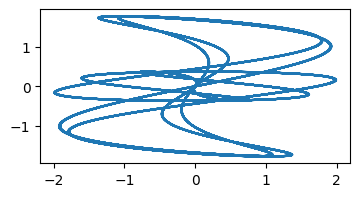

In [12]:
Time = np.linspace(0,40,2000)
signal_2D = np.array([np.sin(3.5*np.pi*Time) + np.sin(5*np.pi*Time), np.sin(1*np.pi*Time) + np.sin(2*np.pi*Time)])
plt.figure(figsize = (4,2))
plt.plot(signal_2D[0], signal_2D[1])
plt.show()

In [13]:
N = 1000

dt = 0.2
beta = 1e-4
initTraining = 200

sigma = 1
mu = 0.

In [14]:
ESNet = ESN(N, signal_2D.T, dt, beta, initTraining, sigma, mu)
trained_output, MSE = ESNet.train()
print(MSE)

2.2030810314996103e-05


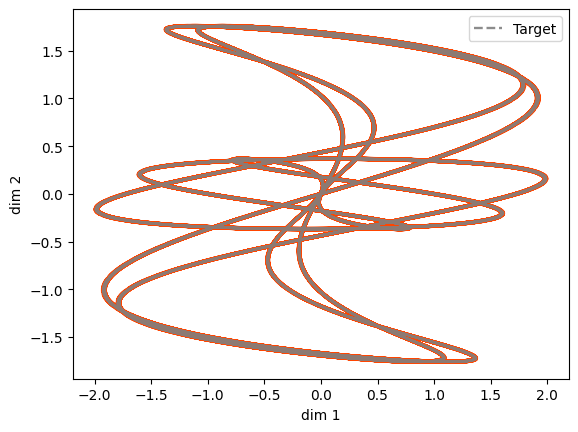

In [15]:
plt.plot(trained_output[0], trained_output[1], lw = 3, color = "orangered")
plt.plot(ESNet.target[0], ESNet.target[1], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.legend()
plt.show()

In [16]:
start_echo_state = 150
duration = 800
echo_output = ESNet.echo_state(start_echo_state, duration = duration)

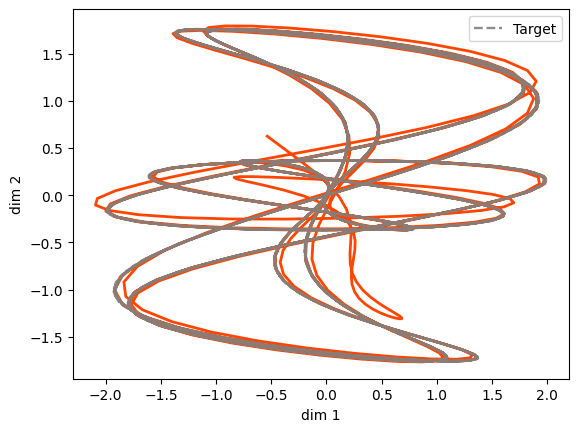

In [17]:
plt.plot(echo_output[0], echo_output[1], lw = 2, color = "orangered")
plt.plot(ESNet.target[0], ESNet.target[1], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.legend()
plt.show()

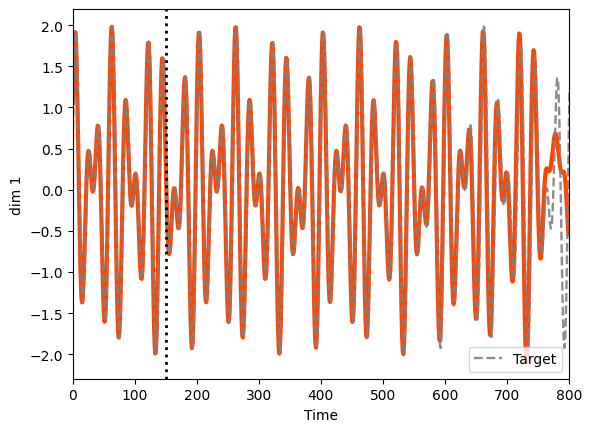

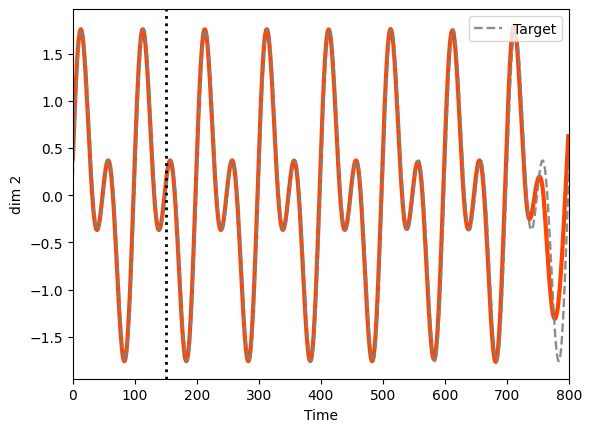

In [18]:
plt.plot(echo_output[0], lw = 3, color = "orangered")
plt.plot(ESNet.target[0], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(0,duration)
plt.xlabel("Time")
plt.ylabel("dim 1")
plt.axvline(start_echo_state, ls = "dotted", c = 'k', lw = 2)
plt.legend()
plt.show()

plt.plot(echo_output[1], lw = 3, color = "orangered")
plt.plot(ESNet.target[1], ls = '--', c = 'gray', lw = 1.7, alpha = 0.9, label = "Target")
plt.xlim(0,duration)
plt.xlabel("Time")
plt.ylabel("dim 2")
plt.axvline(start_echo_state, ls = "dotted", c = 'k', lw = 2)
plt.legend()
plt.show()